##O Problema:

Imagine que você foi escalado para um time de investimentos e precisarpa realizar um modelo preditivo de dados da IBOVESPA(Bolsa de Valores) para criar uma série temporal e prever diariamente o fechamento da Base.

Para isso utilize a base de dados contida no site da investing (https://br.investing.com/indices/bovespa-historical-data) e selecione o período diário, com o intervalo de tempo que achar adequado.

Você precisará demonstrar para o time de investimentos:



*   O modelo com o storytelling, desde a captura do dado até a entrega do modelo;
*   Justificar a técnica utilizada;
*   Atingir uma acuracidade adequada (acima de 70%)



##Importando Bibliotecas a serem utilizadas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

#decomposição
from statsmodels.tsa.seasonal import seasonal_decompose

#teste Estatistico de Fuller (PValue)
from statsmodels.tsa.stattools import adfuller

#Auto Correlação (ACF) Auto correlação Parcial (PACF)
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

##Importando a Base de Dados da IBOVESPA

Utilizando a biblioteca Python 'yfinance' que possui os dados diários através do link(https://finance.yahoo.com/quote/%5EBVSP/history/)

In [3]:
#Dados Da Bolsa importado diretamente do Python

import yfinance as yf

start_date = '2007-01-01'
end_date = '2024-07-05'

df_origem = yf.download('^BVSP', start=start_date, end=end_date)

df_origem.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-06-28,124308.0,124500.0,123298.0,123907.0,123907.0,9070800
2024-07-01,123905.0,125220.0,123735.0,124718.0,124718.0,0
2024-07-02,124720.0,125491.0,124310.0,124787.0,124787.0,8368000
2024-07-03,124787.0,126581.0,124787.0,125662.0,125662.0,8534200
2024-07-04,125666.0,126660.0,125666.0,126164.0,126164.0,6535700


In [4]:
#Criando novo DataFrame somente com a coluna do Fechamento "Close" e renomeando para Y

df = df_origem[['Close']].rename(columns={'Close': 'y'})
df.index = pd.to_datetime(df.index,format= "%Y-%m-%d").rename('ds')

# Set the frequency of the DatetimeIndex, for example to daily 'D'
#df = df.asfreq('D')

# Remove the missing values
#df = df.dropna()

df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4332 entries, 2007-01-02 to 2024-07-04
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       4332 non-null   float64
dtypes: float64(1)
memory usage: 67.7 KB


In [5]:
df.head()

,y
ds,
2007-01-02,45383.0
2007-01-03,44445.0
2007-01-04,44020.0
2007-01-05,42245.0
2007-01-08,42830.0


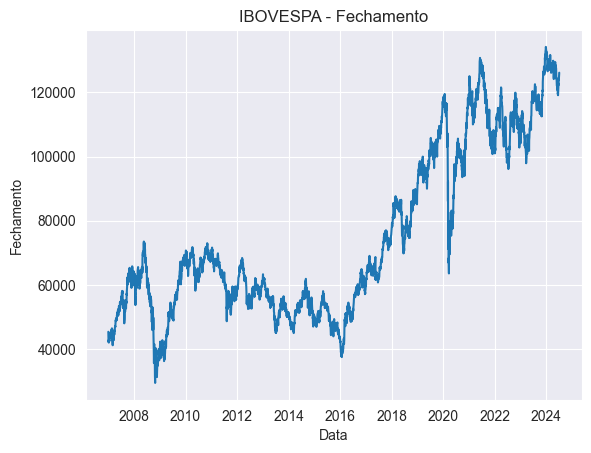

In [6]:
#Plot com os dados de Fechamento da Bolsa

plt.plot(df.index, df.y)
plt.title('IBOVESPA - Fechamento')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.show()

##Decomposição

In [8]:
##Duvida ##Não entendi pq tenho q definir um periodo

resultados = seasonal_decompose(df,period=365)

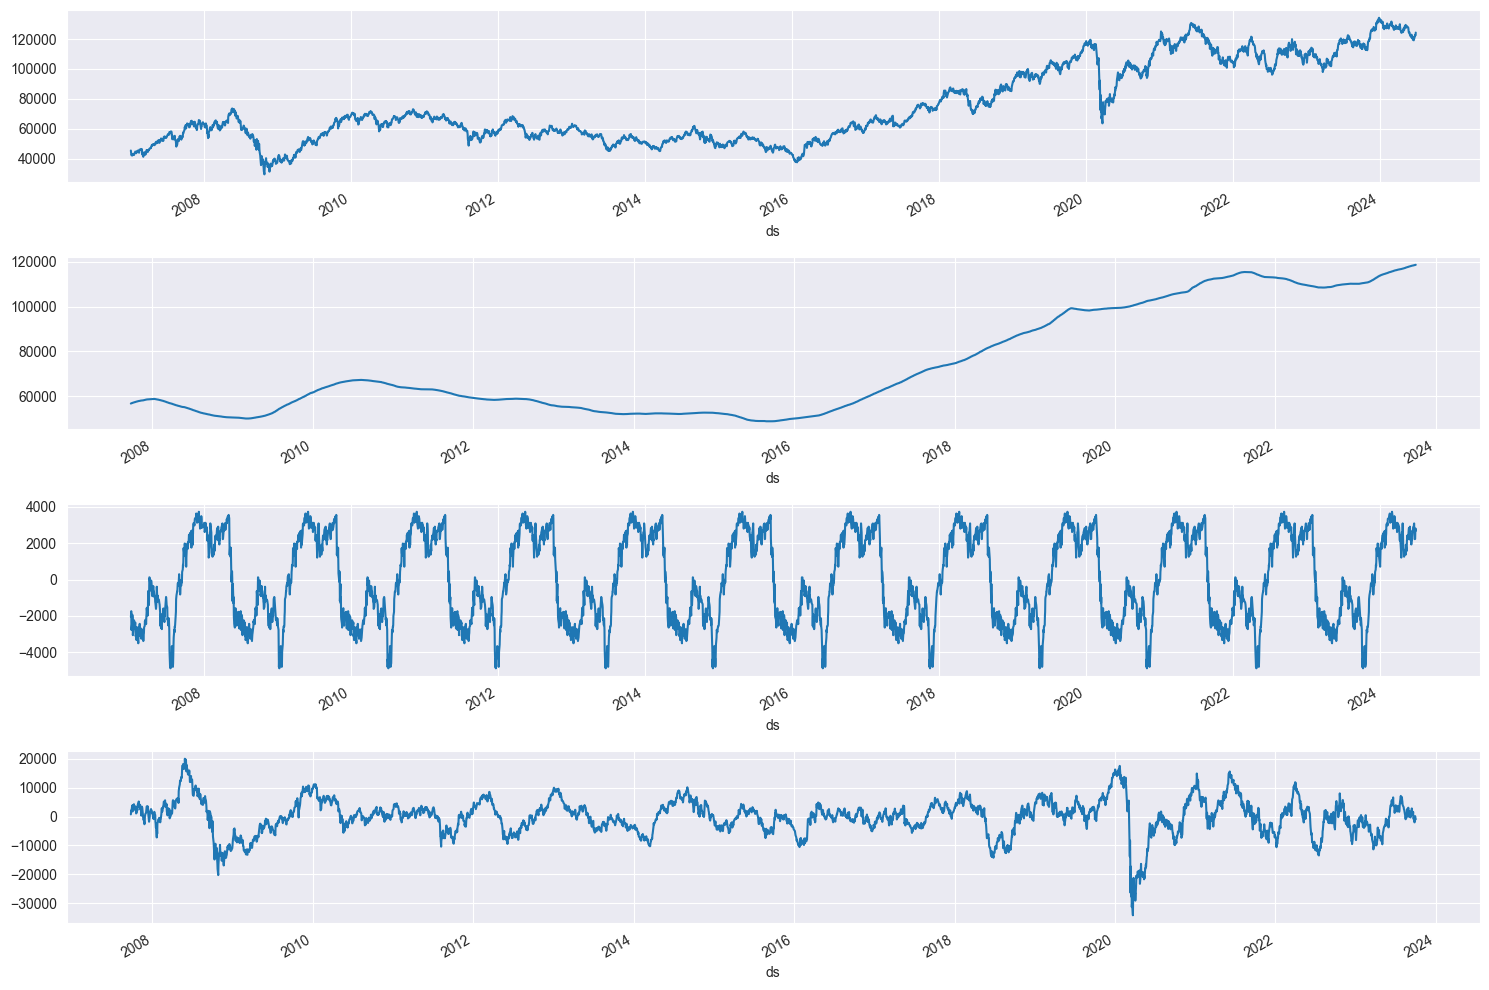

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15,10))

resultados.observed.plot(ax=ax1)
#Tendecia
resultados.trend.plot(ax=ax2)
#Sazonalidade
resultados.seasonal.plot(ax=ax3)
#Residuo
resultados.resid.plot(ax=ax4)

plt.tight_layout()

##Teste Estatístico - Fuller

In [10]:
X = df.y.values

In [11]:
results = adfuller(X)

print("Teste ADF")
print(f"Teste Estatistico: {results[0]}")
print(f"P-Value: {results[1]}")
print("Valores criticos:")

for key, value in results[4].items():
  print(f"{key}: {value}")

Teste ADF
Teste Estatistico: -1.2366137668704738
P-Value: 0.6576504976130009
Valores criticos:
1%: -3.4318663834106182
5%: -2.8622100540854554
10%: -2.5671266746199155


Criando Média Móvel (MA)

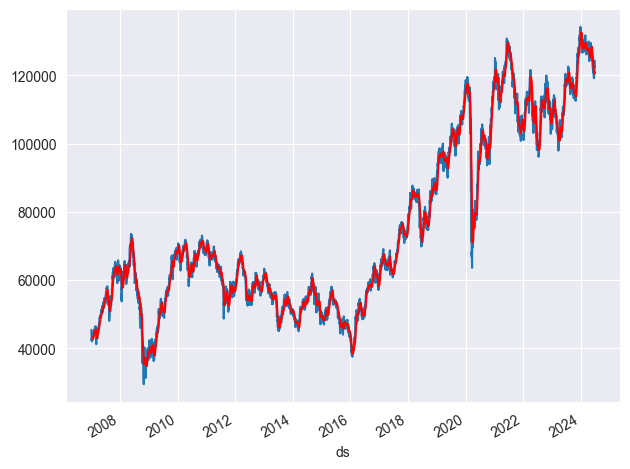

In [12]:
ma = df.rolling(12).mean()

f, ax = plt.subplots()
df.plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

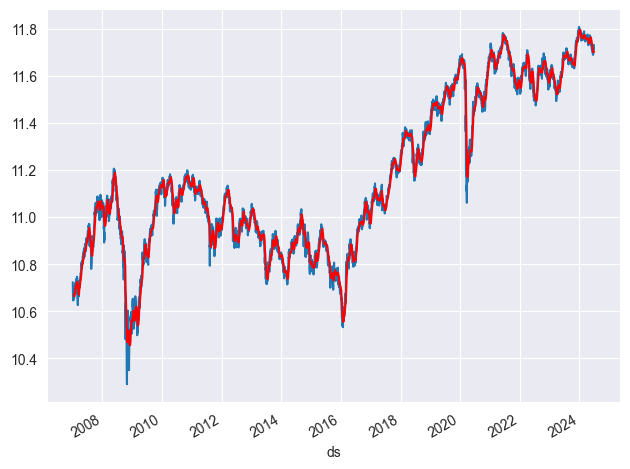

In [13]:
#Aplica Logaritimo para remover as medias moveis

df_log = np.log(df)
ma_log = df_log.rolling(12).mean()

f, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

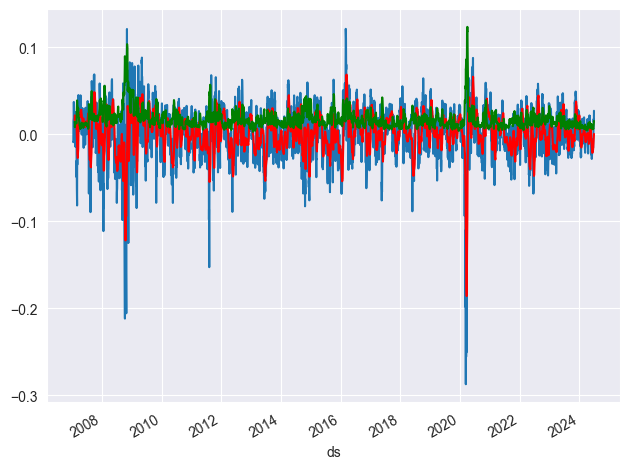

In [14]:
df_s = (df_log - ma_log).dropna() #dropa os nulos

ma_s = df_s.rolling(12).mean()

std = df_s.rolling(12).std()

f, ax = plt.subplots()
df_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
plt.tight_layout()


In [15]:
X_s = df_s.y.values


results_S = adfuller(X_s)

print("Teste ADF")
print(f"Teste Estatistico: {results_S[0]}")
print(f"P-Value: {results_S[1]}")
print("Valores criticos:")

for key, value in results_S[4].items():
  print(f"{key}: {value}")

Teste ADF
Teste Estatistico: -13.915869353284577
P-Value: 5.405065631087459e-26
Valores criticos:
1%: -3.4318702612409275
5%: -2.862211767169501
10%: -2.5671275865819467


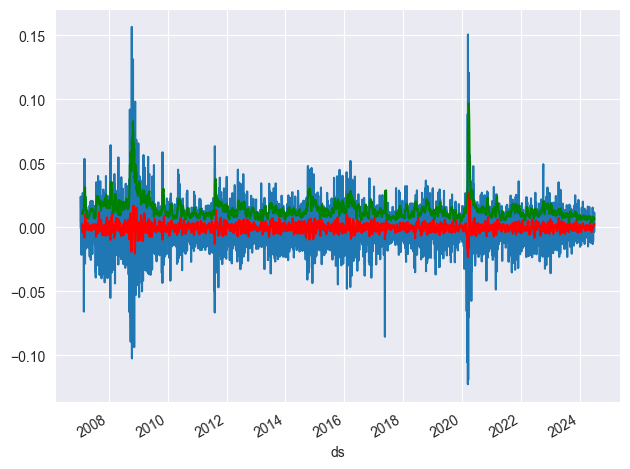

In [16]:
#Aplicar a diferenciação para suavizar ainda mais a serie estacionaria


df_diff = df_s.diff(1)  #1 -- primeira derivada
ma_diff = df_diff.rolling(12).mean()

std_diff = df_diff.rolling(12).std()

f, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()


In [17]:
X_diff = df_diff.y.dropna().values
results_diff = adfuller(X_diff)

print("Teste ADF")
print(f"Teste Estatistico: {results_diff[0]}")
print(f"P-Value: {results_diff[1]}")
print("Valores criticos:")

for key, value in results_diff[4].items():
  print(f"{key}: {value}")

Teste ADF
Teste Estatistico: -18.404191874139492
P-Value: 2.189762491143005e-30
Valores criticos:
1%: -3.4318773628918766
5%: -2.8622149044141842
10%: -2.567129256698322


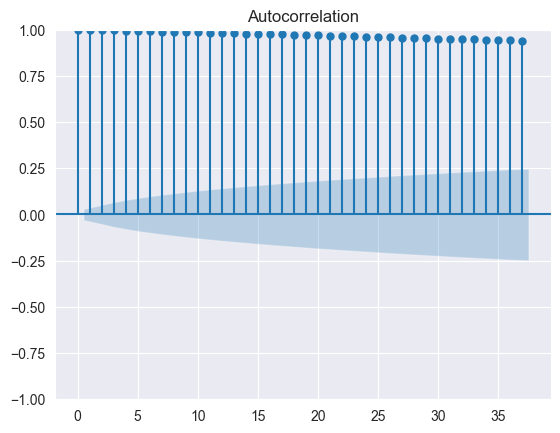

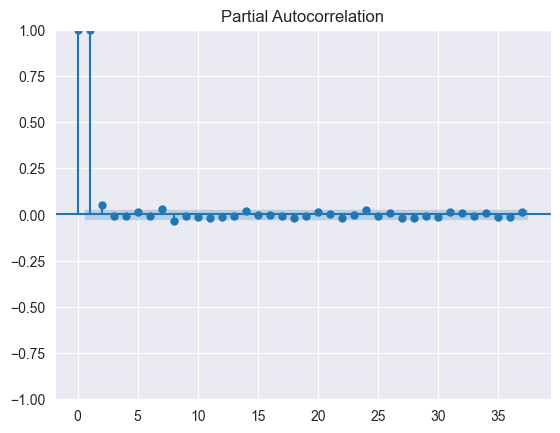

In [19]:
plot_acf(df.y)
plot_pacf(df.y)
plt.show()

#teste